# Dataset creation
First we import the spotipy library to easily interface with the Spotify API, and <b>get the saved tracks</b>

In [49]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

client_id = 'data'
client_secret = 'data'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                                           client_secret=client_secret,
                                                           redirect_uri="http://localhost:8888/callback",
                                                           scope="user-library-read"))

def enumerate_genre(genres):
    genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'indie', 6: 'rock', 7: 'hip-hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

        

# Preprocessing
## Feature selection
We discard the following features:
- track links, IDs and similar metadata.
- Speechiness is redundant since we already have acousticness, and we also don't care about non-musical content (i.e. podcasts or audiobooks).
- Key is not useful since I don't have perfect pitch, and don't really care about it when listening to music.
- Liveness since I don't really care if a song was recorded live or in studio (most of them are in studio anyway).
- Mode is reduntant since we have Valence, that best portrays the mood of the song (and the mode distribution is almost equiprobable).
- duration_ms is irrelevant since the vast majority of songs is in the 3-5 minutes range (and I really don't care about it)
## Discretization
pgmpy does not fully support continuous inference, so to avoid missing values and ease the inference process, kbins discretization is performed (using sklearn), transforming continuous features into discrete ones, in range [0,1]




In [50]:
#insert all preprocessing here, starting from track_features (a list of dictionaries)
def preprocessing(track_features, like):            
    #transform to dataframe
    df=[]
    for i in range(len(track_features)):
        df.append(pd.DataFrame(track_features[i]))
    df = pd.concat(df)
    #feature selection
    df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
    df["like"]=like
    # discretization using sklearn.preprocessing.KBinsDiscretizer
    from sklearn.preprocessing import KBinsDiscretizer
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    
    df['loudness'] = pd.cut(df['loudness'], bins=5, labels=[0,1,2,3,4])
    df['valence'] = pd.cut(df['valence'], bins=5, labels=[0,1,2,3,4])
    df['acousticness'] = pd.cut(df['acousticness'], bins=5, labels=[0,1,2,3,4])
    df['danceability'] = pd.cut(df['danceability'], bins=5, labels=[0,1,2,3,4])
    df['energy'] = pd.cut(df['energy'], bins=5, labels=[0,1,2,3,4])
    df['instrumentalness']= df["instrumentalness"].apply(lambda x: 1 if x>0.5 else 0)
    #return final dataframe
    return df

# Data Retrieving and visualization
## Retrieve liked songs

In [51]:


offset = 0
#get all saved tracks from spotify changing offset to get all tracks
numSongs=400
track_features = []
while True:
    results=sp.current_user_saved_tracks(limit=50,offset=offset)
    for item in results['items']:
        track = item['track']
        #get track supergenere from song's album
        try:
            track_genres = sp.artist(track['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genres)
            if(g==0):
                continue
        except:
            continue
        track_features.append(sp.audio_features(track['id']))
        #add column genre
        track_features[-1][0]['genre'] = g
        #print in real time the number of retrieved songs, delete after each print
        print("number of retrieved songs:", len(track_features), end="\r")
        if(len(track_features)>=numSongs):
            break
    if(len(track_features)>=numSongs):
        break
    offset+=50


#only get 150 random songs
import random
random.shuffle(track_features)
track_features = track_features[:300]
df=preprocessing(track_features, 1)

<hr>


## Retrieve songs I dislike
I'll use:
- the top 50 charts of US, IT and UK with the (probably wrong) assumption that I dislike most of them (150 songs)
- an EDM playlist with >200 songs<br>
then I randomly sample only 150 of the total

In [53]:
top50=[]
linkPlaylistEDM='https://open.spotify.com/playlist/2e3dcRuo9uDH6qD3NOGKAL?si=cf3587f0d60647de'
linkPlaylistTrapIta="https://open.spotify.com/playlist/3Ezbwch2m46WbbZ8Uq76h4"
playlists=[linkPlaylistEDM, linkPlaylistTrapIta]

#get top 50 songs in US, IT and great britain
markets=['US', 'IT', 'GB']
for market in markets:
    results = sp.search(q='year:2022', type='track', limit=50, offset=0, market=market)
    #get features
    for i in range(len(results['tracks']['items'])):
        #get track supergenere from artist
        try:
            track_genre = sp.artist(results['tracks']['items'][i]['artists'][0]['id'])['genres']
            g=enumerate_genre(track_genre)
            if(g==0):
                continue
        except:
            continue
        top50.append(sp.audio_features(results['tracks']['items'][i]['id']))
        print("number of retrieved songs:", len(top50), end="\r")
        #add column genre
        top50[-1][0]['genre'] = g


In [55]:
#do same thing with trap playlist
for playlist in playlists:
    offset=0
    while True:
        #get tracks from link playlist
        results = sp.playlist_tracks(playlist, limit=50, offset=offset)    
        for i in range(len(results['items'])):
            #get track supergenere from artist
            try:
                track_genre = sp.artist(results['items'][i]['track']['artists'][0]['id'])['genres']
                g=enumerate_genre(track_genre)
                #check if g is NaN
                if(g==0 or g==np.nan):
                    continue
            except:
                continue
            audio_features = sp.audio_features(results['items'][i]['track']['id'])
            if(audio_features==[None]):
                continue
            top50.append(audio_features)
            print("number of retrieved songs:", len(top50), end="\r")
            #add column genre
            top50[-1][0]['genre'] = g
            
        offset+=50
        if offset>=results['total']:
            break
#convert to dataframe
#take only 150 random songs
random.shuffle(top50)
top50 = top50[:300]
dfDislike=preprocessing(top50, 0)


/tmp/ipykernel_4226/1793565281.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dfUnified.corr(),annot=True, fmt=".2f")


<AxesSubplot: >

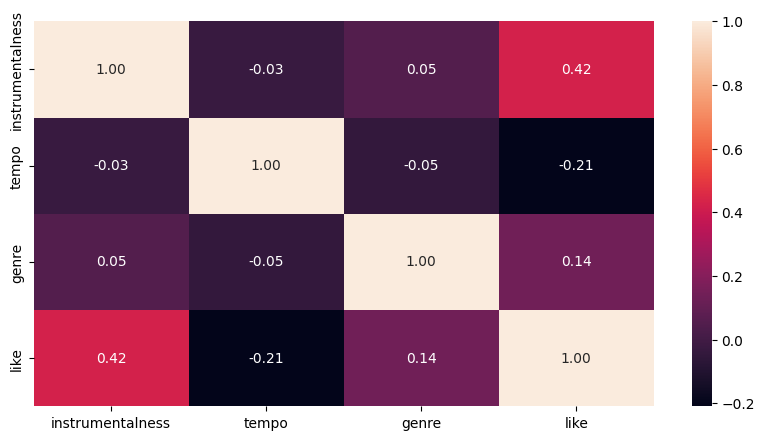

In [56]:
#create unified dataframe with likes and dislikes
dfUnified=pd.concat([df,dfDislike])

Save data in CSV file

In [57]:
dfUnified.to_csv('spotifyData.csv')

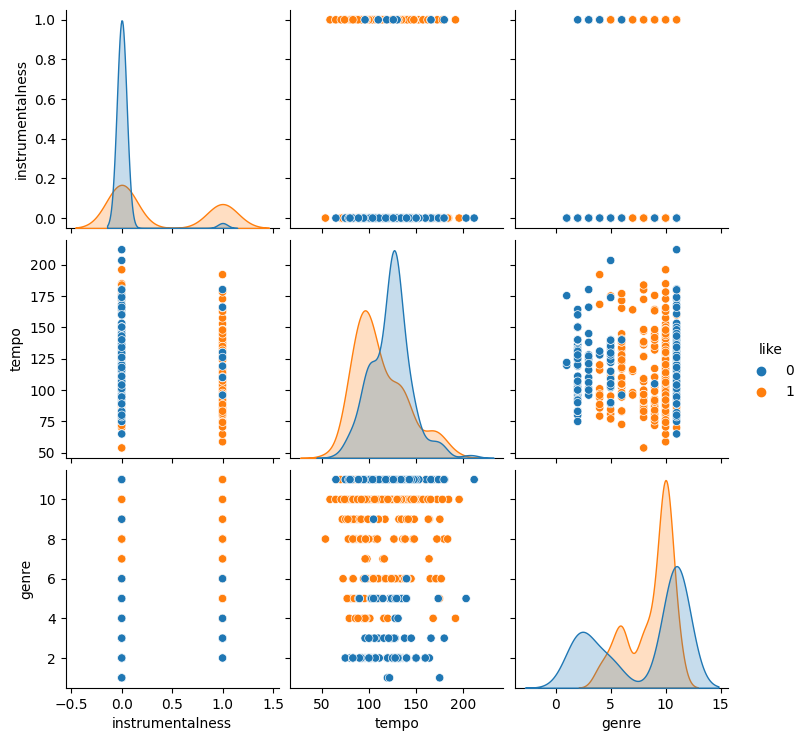

In [58]:
#pairplot
sns.pairplot(dfUnified, hue='like')

In [59]:
dfUnified.value_counts("like")

like
0    300
1    300
dtype: int64

# References
- Spotify API documentation: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features 
- Similar project on Kaggle (but not with Bayesian networks): 